# Import

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import random
import numpy as np
from pdg_const1 import pdg
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import sys
import time
from helperfunctions import display_time, prepare_plot
import cmath as c
import scipy.integrate as integrate
from scipy.optimize import fminbound
from array import array as arr
import collections
from itertools import compress
import tensorflow as tf
import zfit
from zfit import ztf
# from IPython.display import clear_output
import os
import tensorflow_probability as tfp
tfd = tfp.distributions

from matplotlib.pyplot import figure

C:\Users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\util\execution.py:57: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
# chunksize = 10000
# zfit.run.chunking.active = True
# zfit.run.chunking.max_n_points = chunksize

# Build model and graphs
## Create graphs

In [4]:
def formfactor(q2, subscript, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2): #returns real value
    #check if subscript is viable

    if subscript != "0" and subscript != "+" and subscript != "T":
        raise ValueError('Wrong subscript entered, choose either 0, + or T')

    #get constants

    mK = ztf.constant(pdg['Ks_M'])
    mbstar0 = ztf.constant(pdg["mbstar0"])
    mbstar = ztf.constant(pdg["mbstar"])


    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #N comes from derivation in paper

    N = 3

    #some helperfunctions

    tpos = (mB - mK)**2
    tzero = (mB + mK)*(ztf.sqrt(mB)-ztf.sqrt(mK))**2

    z_oben = ztf.sqrt(tpos - q2) - ztf.sqrt(tpos - tzero)
    z_unten = ztf.sqrt(tpos - q2) + ztf.sqrt(tpos - tzero)
    z = tf.divide(z_oben, z_unten)

    #calculate f0

    if subscript == "0":
        prefactor = 1/(1 - q2/(mbstar0**2))
        _sum = 0
        b0 = [b0_0, b0_1, b0_2]

        for i in range(N):
            _sum += b0[i]*(tf.pow(z,i))

        return ztf.to_complex(prefactor * _sum)

    #calculate f+ or fT

    else:
        prefactor = 1/(1 - q2/(mbstar**2))
        _sum = 0

        if subscript == "T":
            bT = [bT_0, bT_1, bT_2]
            for i in range(N):
                _sum += bT[i] * (tf.pow(z, i) - ((-1)**(i-N)) * (i/N) * tf.pow(z, N))
        else:
            bplus = [bplus_0, bplus_1, bplus_2]
            for i in range(N):
                _sum += bplus[i] * (tf.pow(z, i) - ((-1)**(i-N)) * (i/N) * tf.pow(z, N))

        return ztf.to_complex(prefactor * _sum)

def resonance(q, _mass, width, phase, scale):

    q2 = tf.pow(q, 2)

    mmu = ztf.constant(pdg['muon_M'])

    p = 0.5 * ztf.sqrt(q2 - 4*(mmu**2))

    p0 =  0.5 * ztf.sqrt(_mass**2 - 4*mmu**2)

    gamma_j = tf.divide(p, q) * _mass * width / p0

    #Calculate the resonance

    _top = tf.complex(_mass * width, ztf.constant(0.0))

    _bottom = tf.complex(_mass**2 - q2, -_mass*gamma_j)

    com = _top/_bottom

    #Rotate by the phase

    r = ztf.to_complex(scale*tf.abs(com))

    _phase = tf.angle(com)

    _phase += phase

    com = r * tf.exp(tf.complex(ztf.constant(0.0), _phase))

    return com


def axiv_nonres(q, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2):

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C10eff = ztf.constant(pdg['C10eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    q2 = tf.pow(q, 2)

    #Some helperfunctions

    beta = 1. - 4. * mmu**2. / q2

    kabs = ztf.sqrt(mB**2. + tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2. * (mB**2. * mK**2. + mK**2. * q2 + mB**2. * q2) / mB**2.)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2. * kabs * beta / (128. * np.pi**5.)

    #left term in bracket

    bracket_left = 2./3. * tf.pow(kabs,2) * tf.pow(beta,2) * tf.pow(tf.abs(ztf.to_complex(C10eff)*formfactor(q2, "+", b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)),2)

    #middle term in bracket

    _top = 4. * mmu**2. * (mB**2. - mK**2.) * (mB**2. - mK**2.)

    _under = q2 * mB**2.

    bracket_middle = _top/_under *tf.pow(tf.abs(ztf.to_complex(C10eff) * formfactor(q2, "0", b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)), 2)
    
    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * (bracket_left + bracket_middle) * 2 * q

def vec(q, funcs, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2):
    
    q2 = tf.pow(q, 2)

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C7eff = ztf.constant(pdg['C7eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #Some helperfunctions

    beta = 1. - 4. * mmu**2. / q2

    kabs = ztf.sqrt(mB**2. + tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2 * (mB**2 * mK**2 + mK**2 * q2 + mB**2 * q2) / mB**2)
    
    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2 * kabs * beta / (128. * np.pi**5.)

    #right term in bracket

    prefactor2 = tf.pow(kabs,2) * (1. - 1./3. * beta)

    abs_bracket = tf.pow(tf.abs(c9eff(q, funcs) * formfactor(q2, "+", b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2) + ztf.to_complex(2.0 * C7eff * (mb + ms)/(mB + mK)) * formfactor(q2, "T", b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)),2)

    bracket_right = prefactor2 * abs_bracket

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * bracket_right * 2 * q

def c9eff(q, funcs):

    C9eff_nr = ztf.to_complex(ztf.constant(pdg['C9eff']))

    c9 = C9eff_nr + funcs

    return c9

In [5]:
def G(y):
    
    def inner_rect_bracket(q):
        return tf.log(ztf.to_complex((1+tf.sqrt(q))/(1-tf.sqrt(q)))-tf.complex(ztf.constant(0), -1*ztf.constant(np.pi)))    
    
    def inner_right(q):
        return ztf.to_complex(2 * tf.atan(1/tf.sqrt(tf.math.real(-q))))
    
    big_bracket = tf.where(tf.math.real(y) > ztf.constant(0.0), inner_rect_bracket(y), inner_right(y))
    
    return ztf.to_complex(tf.sqrt(tf.abs(y))) * big_bracket

def h_S(m, q):
    
    return ztf.to_complex(2) - G(ztf.to_complex(1) - ztf.to_complex(4*tf.pow(m, 2)) / ztf.to_complex(tf.pow(q, 2)))

def h_P(m, q):
    
    return ztf.to_complex(2/3) + (ztf.to_complex(1) - ztf.to_complex(4*tf.pow(m, 2)) / ztf.to_complex(tf.pow(q, 2))) * h_S(m,q)

def two_p_ccbar(mD, m_D_bar, m_D_star, q):
    
    
    #Load constants
    nu_D_bar = ztf.to_complex(pdg["nu_D_bar"])
    nu_D = ztf.to_complex(pdg["nu_D"])
    nu_D_star = ztf.to_complex(pdg["nu_D_star"])
    
    phase_D_bar = ztf.to_complex(pdg["phase_D_bar"])
    phase_D = ztf.to_complex(pdg["phase_D"])
    phase_D_star = ztf.to_complex(pdg["phase_D_star"])
    
    #Calculation
    left_part =  nu_D_bar * tf.exp(tf.complex(ztf.constant(0.0), phase_D_bar)) * h_S(m_D_bar, q) 
    
    right_part_D = nu_D * tf.exp(tf.complex(ztf.constant(0.0), phase_D)) * h_P(m_D, q) 
    
    right_part_D_star = nu_D_star * tf.exp(tf.complex(ztf.constant(0.0), phase_D_star)) * h_P(m_D_star, q) 

    return left_part + right_part_D + right_part_D_star

## Build pdf

In [6]:
class total_pdf_cut(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['b0_0', 'b0_1', 'b0_2', 
               'bplus_0', 'bplus_1', 'bplus_2', 
               'bT_0', 'bT_1', 'bT_2', 
               'rho_mass', 'rho_scale', 'rho_phase', 'rho_width',
               'jpsi_mass', 'jpsi_scale', 'jpsi_phase', 'jpsi_width',
               'psi2s_mass', 'psi2s_scale', 'psi2s_phase', 'psi2s_width',
               'p3770_mass', 'p3770_scale', 'p3770_phase', 'p3770_width',
               'p4040_mass', 'p4040_scale', 'p4040_phase', 'p4040_width',
               'p4160_mass', 'p4160_scale', 'p4160_phase', 'p4160_width',
               'p4415_mass', 'p4415_scale', 'p4415_phase', 'p4415_width',
               'omega_mass', 'omega_scale', 'omega_phase', 'omega_width',
               'phi_mass', 'phi_scale', 'phi_phase', 'phi_width',
               'Dbar_mass', 'Dbar_scale', 'Dbar_phase',
               'Dstar_mass', 'DDstar_scale', 'DDstar_phase', 'D_mass',
               'tau_mass', 'C_tt']
# the name of the parameters

    def _unnormalized_pdf(self, x):
        
        x = x.unstack_x()
        
        b0 = [self.params['b0_0'], self.params['b0_1'], self.params['b0_2']]
        bplus = [self.params['bplus_0'], self.params['bplus_1'], self.params['bplus_2']]
        bT = [self.params['bT_0'], self.params['bT_1'], self.params['bT_2']]
        
        def rho_res(q):
            return resonance(q, _mass = self.params['rho_mass'], scale = self.params['rho_scale'],
                             phase = self.params['rho_phase'], width = self.params['rho_width'])
    
        def omega_res(q):
            return resonance(q, _mass = self.params['omega_mass'], scale = self.params['omega_scale'],
                             phase = self.params['omega_phase'], width = self.params['omega_width'])
        
        def phi_res(q):
            return resonance(q, _mass = self.params['phi_mass'], scale = self.params['phi_scale'],
                             phase = self.params['phi_phase'], width = self.params['phi_width'])

        def jpsi_res(q):
            return  ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['jpsi_mass'], 2)) * resonance(q, _mass = self.params['jpsi_mass'], 
                                                                                  scale = self.params['jpsi_scale'],
                                                                                  phase = self.params['jpsi_phase'], 
                                                                                  width = self.params['jpsi_width'])
        def psi2s_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['psi2s_mass'], 2)) * resonance(q, _mass = self.params['psi2s_mass'], 
                                                                                   scale = self.params['psi2s_scale'],
                                                                                   phase = self.params['psi2s_phase'], 
                                                                                   width = self.params['psi2s_width'])
        def p3770_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p3770_mass'], 2)) * resonance(q, _mass = self.params['p3770_mass'], 
                                                                                   scale = self.params['p3770_scale'],
                                                                                   phase = self.params['p3770_phase'], 
                                                                                   width = self.params['p3770_width'])
        
        def p4040_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4040_mass'], 2)) * resonance(q, _mass = self.params['p4040_mass'], 
                                                                                   scale = self.params['p4040_scale'],
                                                                                   phase = self.params['p4040_phase'], 
                                                                                   width = self.params['p4040_width'])
        
        def p4160_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4160_mass'], 2)) * resonance(q, _mass = self.params['p4160_mass'], 
                                                                                   scale = self.params['p4160_scale'],
                                                                                   phase = self.params['p4160_phase'], 
                                                                                   width = self.params['p4160_width'])
        
        def p4415_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4415_mass'], 2)) * resonance(q, _mass = self.params['p4415_mass'], 
                                                                                   scale = self.params['p4415_scale'],
                                                                                   phase = self.params['p4415_phase'], 
                                                                                   width = self.params['p4415_width'])
        
        def P2_D(q):
            Dbar_contrib = ztf.to_complex(self.params['Dbar_scale'])*tf.exp(tf.complex(ztf.constant(0.0), self.params['Dbar_phase']))*ztf.to_complex(h_S(self.params['Dbar_mass'], q))
            DDstar_contrib = ztf.to_complex(self.params['DDstar_scale'])*tf.exp(tf.complex(ztf.constant(0.0), self.params['DDstar_phase']))*(ztf.to_complex(h_P(self.params['Dstar_mass'], q)) + ztf.to_complex(h_P(self.params['D_mass'], q)))
            return Dbar_contrib + DDstar_contrib
        
        def ttau_cusp(q):
            return ztf.to_complex(self.params['C_tt'])*(ztf.to_complex((h_S(self.params['tau_mass'], q))) - ztf.to_complex(h_P(self.params['tau_mass'], q)))
        

        funcs = rho_res(x) + omega_res(x) + phi_res(x) + jpsi_res(x) + psi2s_res(x) + p3770_res(x) + p4040_res(x)+ p4160_res(x) + p4415_res(x) + P2_D(x) + ttau_cusp(x)

        vec_f = vec(x, funcs, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)

        axiv_nr = axiv_nonres(x, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)

        tot = vec_f + axiv_nr
        
        #Cut out jpsi and psi2s
        
        tot = tf.where(tf.math.logical_or(x < ztf.constant(jpsi_mass-60.), x > ztf.constant(jpsi_mass+70.)), tot, 0.0*tot)
        
        tot = tf.where(tf.math.logical_or(x < ztf.constant(psi2s_mass-50.), x > ztf.constant(psi2s_mass+50.)), tot, 0.0*tot)
        
        return tot
    
class total_pdf_full(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['b0_0', 'b0_1', 'b0_2', 
               'bplus_0', 'bplus_1', 'bplus_2', 
               'bT_0', 'bT_1', 'bT_2', 
               'rho_mass', 'rho_scale', 'rho_phase', 'rho_width',
               'jpsi_mass', 'jpsi_scale', 'jpsi_phase', 'jpsi_width',
               'psi2s_mass', 'psi2s_scale', 'psi2s_phase', 'psi2s_width',
               'p3770_mass', 'p3770_scale', 'p3770_phase', 'p3770_width',
               'p4040_mass', 'p4040_scale', 'p4040_phase', 'p4040_width',
               'p4160_mass', 'p4160_scale', 'p4160_phase', 'p4160_width',
               'p4415_mass', 'p4415_scale', 'p4415_phase', 'p4415_width',
               'omega_mass', 'omega_scale', 'omega_phase', 'omega_width',
               'phi_mass', 'phi_scale', 'phi_phase', 'phi_width',
               'Dbar_mass', 'Dbar_scale', 'Dbar_phase',
               'Dstar_mass', 'DDstar_scale', 'DDstar_phase', 'D_mass',
               'tau_mass', 'C_tt']
# the name of the parameters

    def _unnormalized_pdf(self, x):
        
        x = x.unstack_x()
        
        b0 = [self.params['b0_0'], self.params['b0_1'], self.params['b0_2']]
        bplus = [self.params['bplus_0'], self.params['bplus_1'], self.params['bplus_2']]
        bT = [self.params['bT_0'], self.params['bT_1'], self.params['bT_2']]
        
        def rho_res(q):
            return resonance(q, _mass = self.params['rho_mass'], scale = self.params['rho_scale'],
                             phase = self.params['rho_phase'], width = self.params['rho_width'])
    
        def omega_res(q):
            return resonance(q, _mass = self.params['omega_mass'], scale = self.params['omega_scale'],
                             phase = self.params['omega_phase'], width = self.params['omega_width'])
        
        def phi_res(q):
            return resonance(q, _mass = self.params['phi_mass'], scale = self.params['phi_scale'],
                             phase = self.params['phi_phase'], width = self.params['phi_width'])

        def jpsi_res(q):
            return  ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['jpsi_mass'], 2)) * resonance(q, _mass = self.params['jpsi_mass'], 
                                                                                  scale = self.params['jpsi_scale'],
                                                                                  phase = self.params['jpsi_phase'], 
                                                                                  width = self.params['jpsi_width'])
        def psi2s_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['psi2s_mass'], 2)) * resonance(q, _mass = self.params['psi2s_mass'], 
                                                                                   scale = self.params['psi2s_scale'],
                                                                                   phase = self.params['psi2s_phase'], 
                                                                                   width = self.params['psi2s_width'])
        def p3770_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p3770_mass'], 2)) * resonance(q, _mass = self.params['p3770_mass'], 
                                                                                   scale = self.params['p3770_scale'],
                                                                                   phase = self.params['p3770_phase'], 
                                                                                   width = self.params['p3770_width'])
        
        def p4040_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4040_mass'], 2)) * resonance(q, _mass = self.params['p4040_mass'], 
                                                                                   scale = self.params['p4040_scale'],
                                                                                   phase = self.params['p4040_phase'], 
                                                                                   width = self.params['p4040_width'])
        
        def p4160_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4160_mass'], 2)) * resonance(q, _mass = self.params['p4160_mass'], 
                                                                                   scale = self.params['p4160_scale'],
                                                                                   phase = self.params['p4160_phase'], 
                                                                                   width = self.params['p4160_width'])
        
        def p4415_res(q):
            return ztf.to_complex(tf.pow(q, 2) / tf.pow(self.params['p4415_mass'], 2)) * resonance(q, _mass = self.params['p4415_mass'], 
                                                                                   scale = self.params['p4415_scale'],
                                                                                   phase = self.params['p4415_phase'], 
                                                                                   width = self.params['p4415_width'])
        
        def P2_D(q):
            Dbar_contrib = ztf.to_complex(self.params['Dbar_scale'])*tf.exp(tf.complex(ztf.constant(0.0), self.params['Dbar_phase']))*ztf.to_complex(h_S(self.params['Dbar_mass'], q))
            DDstar_contrib = ztf.to_complex(self.params['DDstar_scale'])*tf.exp(tf.complex(ztf.constant(0.0), self.params['DDstar_phase']))*(ztf.to_complex(h_P(self.params['Dstar_mass'], q)) + ztf.to_complex(h_P(self.params['D_mass'], q)))
            return Dbar_contrib + DDstar_contrib
        
        def ttau_cusp(q):
            return ztf.to_complex(self.params['C_tt'])*(ztf.to_complex((h_S(self.params['tau_mass'], q))) - ztf.to_complex(h_P(self.params['tau_mass'], q)))
        

        funcs = rho_res(x) + omega_res(x) + phi_res(x) + jpsi_res(x) + psi2s_res(x) + p3770_res(x) + p4040_res(x)+ p4160_res(x) + p4415_res(x) + P2_D(x) + ttau_cusp(x)

        vec_f = vec(x, funcs, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)

        axiv_nr = axiv_nonres(x, b0_0, b0_1, b0_2, bplus_0, bplus_1, bplus_2, bT_0, bT_1, bT_2)

        tot = vec_f + axiv_nr
        
        #Cut out jpsi and psi2s
        
#         tot = tf.where(tf.math.logical_or(x < ztf.constant(jpsi_mass-60.), x > ztf.constant(jpsi_mass+70.)), tot, 0.0*tot)
        
#         tot = tf.where(tf.math.logical_or(x < ztf.constant(psi2s_mass-50.), x > ztf.constant(psi2s_mass+50.)), tot, 0.0*tot)
        
        return tot

## Setup parameters

In [7]:
# formfactors

b0_0 = zfit.Parameter("b0_0", ztf.constant(0.292), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)
b0_1 = zfit.Parameter("b0_1", ztf.constant(0.281), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)
b0_2 = zfit.Parameter("b0_2", ztf.constant(0.150), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)

bplus_0 = zfit.Parameter("bplus_0", ztf.constant(0.466), lower_limit = -2.0, upper_limit= 2.0)
bplus_1 = zfit.Parameter("bplus_1", ztf.constant(-0.885), lower_limit = -2.0, upper_limit= 2.0)
bplus_2 = zfit.Parameter("bplus_2", ztf.constant(-0.213), lower_limit = -2.0, upper_limit= 2.0)

bT_0 = zfit.Parameter("bT_0", ztf.constant(0.460), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)
bT_1 = zfit.Parameter("bT_1", ztf.constant(-1.089), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)
bT_2 = zfit.Parameter("bT_2", ztf.constant(-1.114), floating = False) #, lower_limit = -2.0, upper_limit= 2.0)


#rho

rho_mass, rho_width, rho_phase, rho_scale = pdg["rho"]

rho_m = zfit.Parameter("rho_m", ztf.constant(rho_mass), floating = False) #lower_limit = rho_mass - rho_width, upper_limit = rho_mass + rho_width)
rho_w = zfit.Parameter("rho_w", ztf.constant(rho_width), floating = False)
rho_p = zfit.Parameter("rho_p", ztf.constant(rho_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
rho_s = zfit.Parameter("rho_s", ztf.constant(rho_scale), lower_limit=rho_scale-np.sqrt(rho_scale), upper_limit=rho_scale+np.sqrt(rho_scale))

#omega

omega_mass, omega_width, omega_phase, omega_scale = pdg["omega"]

omega_m = zfit.Parameter("omega_m", ztf.constant(omega_mass), floating = False)
omega_w = zfit.Parameter("omega_w", ztf.constant(omega_width), floating = False)
omega_p = zfit.Parameter("omega_p", ztf.constant(omega_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
omega_s = zfit.Parameter("omega_s", ztf.constant(omega_scale), lower_limit=omega_scale-np.sqrt(omega_scale), upper_limit=omega_scale+np.sqrt(omega_scale))


#phi

phi_mass, phi_width, phi_phase, phi_scale = pdg["phi"]

phi_m = zfit.Parameter("phi_m", ztf.constant(phi_mass), floating = False)
phi_w = zfit.Parameter("phi_w", ztf.constant(phi_width), floating = False)
phi_p = zfit.Parameter("phi_p", ztf.constant(phi_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
phi_s = zfit.Parameter("phi_s", ztf.constant(phi_scale), lower_limit=phi_scale-np.sqrt(phi_scale), upper_limit=phi_scale+np.sqrt(phi_scale))

#jpsi

jpsi_mass, jpsi_width, jpsi_phase, jpsi_scale = pdg["jpsi"]

jpsi_m = zfit.Parameter("jpsi_m", ztf.constant(jpsi_mass), floating = False)
jpsi_w = zfit.Parameter("jpsi_w", ztf.constant(jpsi_width), floating = False)
jpsi_p = zfit.Parameter("jpsi_p", ztf.constant(jpsi_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
jpsi_s = zfit.Parameter("jpsi_s", ztf.constant(jpsi_scale), floating = False) #, lower_limit=jpsi_scale-np.sqrt(jpsi_scale), upper_limit=jpsi_scale+np.sqrt(jpsi_scale))

#psi2s

psi2s_mass, psi2s_width, psi2s_phase, psi2s_scale = pdg["psi2s"]

psi2s_m = zfit.Parameter("psi2s_m", ztf.constant(psi2s_mass), floating = False)
psi2s_w = zfit.Parameter("psi2s_w", ztf.constant(psi2s_width), floating = False)
psi2s_p = zfit.Parameter("psi2s_p", ztf.constant(psi2s_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
psi2s_s = zfit.Parameter("psi2s_s", ztf.constant(psi2s_scale), floating = False) #, lower_limit=psi2s_scale-np.sqrt(psi2s_scale), upper_limit=psi2s_scale+np.sqrt(psi2s_scale))

#psi(3770)

p3770_mass, p3770_width, p3770_phase, p3770_scale = pdg["p3770"]

p3770_m = zfit.Parameter("p3770_m", ztf.constant(p3770_mass), floating = False)
p3770_w = zfit.Parameter("p3770_w", ztf.constant(p3770_width), floating = False)
p3770_p = zfit.Parameter("p3770_p", ztf.constant(p3770_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
p3770_s = zfit.Parameter("p3770_s", ztf.constant(p3770_scale), lower_limit=p3770_scale-np.sqrt(p3770_scale), upper_limit=p3770_scale+np.sqrt(p3770_scale))

#psi(4040)

p4040_mass, p4040_width, p4040_phase, p4040_scale = pdg["p4040"]

p4040_m = zfit.Parameter("p4040_m", ztf.constant(p4040_mass), floating = False)
p4040_w = zfit.Parameter("p4040_w", ztf.constant(p4040_width), floating = False)
p4040_p = zfit.Parameter("p4040_p", ztf.constant(p4040_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
p4040_s = zfit.Parameter("p4040_s", ztf.constant(p4040_scale), lower_limit=p4040_scale-np.sqrt(p4040_scale), upper_limit=p4040_scale+np.sqrt(p4040_scale))

#psi(4160)

p4160_mass, p4160_width, p4160_phase, p4160_scale = pdg["p4160"]

p4160_m = zfit.Parameter("p4160_m", ztf.constant(p4160_mass), floating = False)
p4160_w = zfit.Parameter("p4160_w", ztf.constant(p4160_width), floating = False)
p4160_p = zfit.Parameter("p4160_p", ztf.constant(p4160_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
p4160_s = zfit.Parameter("p4160_s", ztf.constant(p4160_scale), lower_limit=p4160_scale-np.sqrt(p4160_scale), upper_limit=p4160_scale+np.sqrt(p4160_scale))

#psi(4415)

p4415_mass, p4415_width, p4415_phase, p4415_scale = pdg["p4415"]

p4415_m = zfit.Parameter("p4415_m", ztf.constant(p4415_mass), floating = False)
p4415_w = zfit.Parameter("p4415_w", ztf.constant(p4415_width), floating = False)
p4415_p = zfit.Parameter("p4415_p", ztf.constant(p4415_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)
p4415_s = zfit.Parameter("p4415_s", ztf.constant(p4415_scale), lower_limit=p4415_scale-np.sqrt(p4415_scale), upper_limit=p4415_scale+np.sqrt(p4415_scale))

Instructions for updating:
Colocations handled automatically by placer.


## Dynamic generation of 2 particle contribution

In [8]:
m_c = 1300

Dbar_phase = 0.0
DDstar_phase = 0.0
Dstar_mass = pdg['Dst_M']
Dbar_mass = pdg['D0_M']
D_mass = pdg['D0_M']

Dbar_s = zfit.Parameter("Dbar_s", ztf.constant(0.0), lower_limit=-0.3, upper_limit=0.3)
Dbar_m = zfit.Parameter("Dbar_m", ztf.constant(Dbar_mass), floating = False)
Dbar_p = zfit.Parameter("Dbar_p", ztf.constant(Dbar_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)#, floating = False)
DDstar_s = zfit.Parameter("DDstar_s", ztf.constant(0.0), lower_limit=-0.3, upper_limit=0.3)#, floating = False)
Dstar_m = zfit.Parameter("Dstar_m", ztf.constant(Dstar_mass), floating = False)
D_m = zfit.Parameter("D_m", ztf.constant(D_mass), floating = False)
DDstar_p = zfit.Parameter("DDstar_p", ztf.constant(DDstar_phase), lower_limit=-2*np.pi, upper_limit=2*np.pi)#, floating = False)

## Tau parameters

In [9]:
tau_m = zfit.Parameter("tau_m", ztf.constant(pdg['tau_M']), floating = False)
Ctt = zfit.Parameter("Ctt", ztf.constant(0.0), lower_limit=-2.5, upper_limit=2.5)

## Load data

In [10]:
x_min = 2*pdg['muon_M']
x_max = (pdg["Bplus_M"]-pdg["Ks_M"]-0.1)

# # Full spectrum

obs_toy = zfit.Space('q', limits = (x_min, x_max))

# Jpsi and Psi2s cut out

obs1 = zfit.Space('q', limits = (x_min, jpsi_mass - 60.))
obs2 = zfit.Space('q', limits = (jpsi_mass + 70., psi2s_mass - 50.))
obs3 = zfit.Space('q', limits = (psi2s_mass + 50., x_max))

obs_fit = obs1 + obs2 + obs3

# with open(r"./data/slim_points/slim_points_toy_0_range({0}-{1}).pkl".format(int(x_min), int(x_max)), "rb") as input_file:
#     part_set = pkl.load(input_file)

# x_part = part_set['x_part']

# x_part = x_part.astype('float64')

# data = zfit.data.Data.from_numpy(array=x_part, obs=obs)

## Setup pdf

In [11]:
total_f = total_pdf_cut(obs=obs_toy, jpsi_mass = jpsi_m, jpsi_scale = jpsi_s, jpsi_phase = jpsi_p, jpsi_width = jpsi_w,
                    psi2s_mass = psi2s_m, psi2s_scale = psi2s_s, psi2s_phase = psi2s_p, psi2s_width = psi2s_w,
                    p3770_mass = p3770_m, p3770_scale = p3770_s, p3770_phase = p3770_p, p3770_width = p3770_w,
                    p4040_mass = p4040_m, p4040_scale = p4040_s, p4040_phase = p4040_p, p4040_width = p4040_w,
                    p4160_mass = p4160_m, p4160_scale = p4160_s, p4160_phase = p4160_p, p4160_width = p4160_w,
                    p4415_mass = p4415_m, p4415_scale = p4415_s, p4415_phase = p4415_p, p4415_width = p4415_w,
                    rho_mass = rho_m, rho_scale = rho_s, rho_phase = rho_p, rho_width = rho_w,
                    omega_mass = omega_m, omega_scale = omega_s, omega_phase = omega_p, omega_width = omega_w,
                    phi_mass = phi_m, phi_scale = phi_s, phi_phase = phi_p, phi_width = phi_w,
                    Dstar_mass = Dstar_m, DDstar_scale = DDstar_s, DDstar_phase = DDstar_p, D_mass = D_m,
                    Dbar_mass = Dbar_m, Dbar_scale = Dbar_s, Dbar_phase = Dbar_p,
                    tau_mass = tau_m, C_tt = Ctt, b0_0 = b0_0, b0_1 = b0_1, b0_2 = b0_2,
                    bplus_0 = bplus_0, bplus_1 = bplus_1, bplus_2 = bplus_2,
                    bT_0 = bT_0, bT_1 = bT_1, bT_2 = bT_2)

total_f_fit = total_pdf_full(obs=obs_fit, jpsi_mass = jpsi_m, jpsi_scale = jpsi_s, jpsi_phase = jpsi_p, jpsi_width = jpsi_w,
                    psi2s_mass = psi2s_m, psi2s_scale = psi2s_s, psi2s_phase = psi2s_p, psi2s_width = psi2s_w,
                    p3770_mass = p3770_m, p3770_scale = p3770_s, p3770_phase = p3770_p, p3770_width = p3770_w,
                    p4040_mass = p4040_m, p4040_scale = p4040_s, p4040_phase = p4040_p, p4040_width = p4040_w,
                    p4160_mass = p4160_m, p4160_scale = p4160_s, p4160_phase = p4160_p, p4160_width = p4160_w,
                    p4415_mass = p4415_m, p4415_scale = p4415_s, p4415_phase = p4415_p, p4415_width = p4415_w,
                    rho_mass = rho_m, rho_scale = rho_s, rho_phase = rho_p, rho_width = rho_w,
                    omega_mass = omega_m, omega_scale = omega_s, omega_phase = omega_p, omega_width = omega_w,
                    phi_mass = phi_m, phi_scale = phi_s, phi_phase = phi_p, phi_width = phi_w,
                    Dstar_mass = Dstar_m, DDstar_scale = DDstar_s, DDstar_phase = DDstar_p, D_mass = D_m,
                    Dbar_mass = Dbar_m, Dbar_scale = Dbar_s, Dbar_phase = Dbar_p,
                    tau_mass = tau_m, C_tt = Ctt, b0_0 = b0_0, b0_1 = b0_1, b0_2 = b0_2,
                    bplus_0 = bplus_0, bplus_1 = bplus_1, bplus_2 = bplus_2,
                    bT_0 = bT_0, bT_1 = bT_1, bT_2 = bT_2)
                   
# print(total_pdf.obs)

# print(calcs_test)

# for param in total_f.get_dependents():
#     print(zfit.run(param))

In [12]:
# total_f_fit.normalization(obs_fit)

## Test if graphs actually work and compute values

In [13]:
# def total_test_tf(xq):

#     def jpsi_res(q):
#         return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

#     def psi2s_res(q):
#         return resonance(q, psi2s_m, psi2s_s, psi2s_p, psi2s_w)

#     def cusp(q):
#         return bifur_gauss(q, cusp_m, sig_L, sig_R, cusp_s)

#     funcs = jpsi_res(xq) + psi2s_res(xq) + cusp(xq)

#     vec_f = vec(xq, funcs)

#     axiv_nr = axiv_nonres(xq)

#     tot = vec_f + axiv_nr
    
#     return tot

# def jpsi_res(q):
#     return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

# calcs = zfit.run(total_test_tf(x_part))



test_q = np.linspace(x_min, x_max, int(2e6))

probs = total_f_fit.pdf(test_q, norm_range=False)

calcs_test = zfit.run(probs)

Ctt.set_value(0.5)

calcs_test1 = zfit.run(probs)

Ctt.set_value(0.0)

Dbar_s.set_value(0.3)

DDstar_s.set_value(0.3)

calcs_test2 = zfit.run(probs)
# res_y = zfit.run(jpsi_res(test_q))
# b0 = [b0_0, b0_1, b0_2]
# bplus = [bplus_0, bplus_1, bplus_2]
# bT = [bT_0, bT_1, bT_2]
# f0_y = zfit.run(tf.math.real(formfactor(test_q,"0", b0, bplus, bT)))
# fplus_y = zfit.run(tf.math.real(formfactor(test_q,"+", b0, bplus, bT)))
# fT_y = zfit.run(tf.math.real(formfactor(test_q,"T", b0, bplus, bT)))

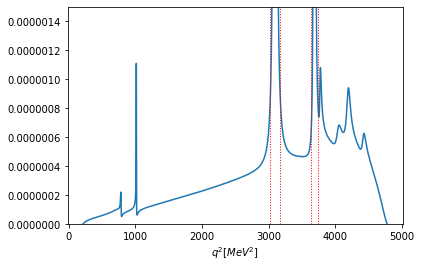

In [14]:
plt.clf()
# plt.plot(x_part, calcs, '.')
plt.plot(test_q, calcs_test)#, label = 'pdf (Ctt = 0.0)')
# plt.plot(test_q, calcs_test1, label = 'pdf (Ctt = 0.5)')
# plt.plot(test_q, calcs_test2, label = 'pdf (D-contribs = 0.3)')
# plt.plot(test_q, f0_y, label = '0')
# plt.plot(test_q, fT_y, label = 'T')
# plt.plot(test_q, fplus_y, label = '+')
# plt.plot(test_q, res_y, label = 'res')
plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.legend()
plt.ylim(0.0, 1.5e-6)
plt.xlabel(r'$q^2 [MeV^2]$')
# plt.yscale('log')
# plt.xlim(770, 785)
plt.savefig('test.png')
# print(jpsi_width)

In [15]:


# probs = mixture.prob(test_q)
# probs_np = zfit.run(probs)
# probs_np *= np.max(calcs_test) / np.max(probs_np)
# plt.figure()
# plt.semilogy(test_q, probs_np,label="importance sampling")
# plt.semilogy(test_q, calcs_test, label = 'pdf')


In [16]:
# 0.213/(0.00133+0.213+0.015)

## Adjust scaling of different parts

In [17]:
total_f.update_integration_options(draws_per_dim=2000000, mc_sampler=None)
# total_f_fit.update_integration_options(draws_per_dim=2000000, mc_sampler=None)
# inte = total_f.integrate(limits = (950., 1050.), norm_range=False)
# inte_fl = zfit.run(inte)
# print(inte_fl/4500)
# print(pdg["jpsi_BR"]/pdg["NR_BR"], inte_fl*pdg["psi2s_auc"]/pdg["NR_auc"])

In [18]:
# # print("jpsi:", inte_fl)
# # print("Increase am by factor:", np.sqrt(pdg["jpsi_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))
# # print("New amp:", pdg["jpsi"][3]*np.sqrt(pdg["jpsi_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))

# # print("psi2s:", inte_fl)
# # print("Increase am by factor:", np.sqrt(pdg["psi2s_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))
# # print("New amp:", pdg["psi2s"][3]*np.sqrt(pdg["psi2s_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))

# name = "phi"

# print(name+":", inte_fl)
# print("Increase am by factor:", np.sqrt(pdg[name+"_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))
# print("New amp:", pdg[name][0]*np.sqrt(pdg[name+"_BR"]/pdg["NR_BR"]*pdg["NR_auc"]/inte_fl))


# print(x_min)
# print(x_max)
# # total_f.update_integration_options(draws_per_dim=2000000, mc_sampler=None)
# total_f.update_integration_options(mc_sampler=lambda dim, num_results,
#                                     dtype: tf.random_uniform(maxval=1., shape=(num_results, dim), dtype=dtype),
#                                    draws_per_dim=1000000)
# # _ = []

# # for i in range(10):

# #     inte = total_f.integrate(limits = (x_min, x_max))
# #     inte_fl = zfit.run(inte)
# #     print(inte_fl)
# #     _.append(inte_fl)

# # print("mean:", np.mean(_))

# _ = time.time()

# inte = total_f.integrate(limits = (x_min, x_max))
# inte_fl = zfit.run(inte)
# print(inte_fl)
# print("Time taken: {}".format(display_time(int(time.time() - _))))

# print(pdg['NR_BR']/pdg['NR_auc']*inte_fl)
# print(0.25**2*4.2/1000)

# Sampling
## Mixture distribution for sampling

In [19]:

    
# print(list_of_borders[:9])
# print(list_of_borders[-9:])


class UniformSampleAndWeights(zfit.util.execution.SessionHolderMixin):
    def __call__(self, limits, dtype, n_to_produce):
        # n_to_produce = tf.cast(n_to_produce, dtype=tf.int32)
        low, high = limits.limit1d
        low = tf.cast(low, dtype=dtype)
        high = tf.cast(high, dtype=dtype)
#         uniform = tfd.Uniform(low=low, high=high)
#         uniformjpsi = tfd.Uniform(low=tf.constant(3080, dtype=dtype), high=tf.constant(3112, dtype=dtype))
#         uniformpsi2s = tfd.Uniform(low=tf.constant(3670, dtype=dtype), high=tf.constant(3702, dtype=dtype))

#         list_of_borders = []
#         _p = []
#         splits = 10

#         _ = np.linspace(x_min, x_max, splits)

#         for i in range(splits):
#             list_of_borders.append(tf.constant(_[i], dtype=dtype))
#             _p.append(tf.constant(1/splits, dtype=dtype))
    
#         mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=_p[:(splits-1)]),
#                                         components_distribution=tfd.Uniform(low=list_of_borders[:(splits-1)], 
#                                                                             high=list_of_borders[-(splits-1):]))
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[tf.constant(0.05, dtype=dtype),
                                                                                    tf.constant(0.93, dtype=dtype),
                                                                                    tf.constant(0.05, dtype=dtype),
                                                                                    tf.constant(0.065, dtype=dtype),
                                                                                    tf.constant(0.04, dtype=dtype),
                                                                                    tf.constant(0.05, dtype=dtype)]),
                                        components_distribution=tfd.Uniform(low=[tf.constant(x_min, dtype=dtype), 
                                                                                 tf.constant(3090, dtype=dtype),
                                                                                 tf.constant(3681, dtype=dtype), 
                                                                                 tf.constant(3070, dtype=dtype),
                                                                                 tf.constant(1000, dtype=dtype),
                                                                                 tf.constant(3660, dtype=dtype)], 
                                                                            high=[tf.constant(x_max, dtype=dtype),
                                                                                  tf.constant(3102, dtype=dtype), 
                                                                                  tf.constant(3691, dtype=dtype),
                                                                                  tf.constant(3110, dtype=dtype),
                                                                                  tf.constant(1040, dtype=dtype),
                                                                                  tf.constant(3710, dtype=dtype)]))
#         dtype = tf.float64
#         mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[tf.constant(0.04, dtype=dtype),
#                                                                                     tf.constant(0.90, dtype=dtype),
#                                                                                     tf.constant(0.02, dtype=dtype),
#                                                                                     tf.constant(0.07, dtype=dtype),
#                                                                                     tf.constant(0.02, dtype=dtype)]),
#                                         components_distribution=tfd.Uniform(low=[tf.constant(x_min, dtype=dtype), 
#                                                                                  tf.constant(3089, dtype=dtype),
#                                                                                  tf.constant(3103, dtype=dtype), 
#                                                                                  tf.constant(3681, dtype=dtype),
#                                                                                  tf.constant(3691, dtype=dtype)], 
#                                                                             high=[tf.constant(3089, dtype=dtype),
#                                                                                   tf.constant(3103, dtype=dtype), 
#                                                                                   tf.constant(3681, dtype=dtype),
#                                                                                   tf.constant(3691, dtype=dtype), 
#                                                                                   tf.constant(x_max, dtype=dtype)]))
#         mixture = tfd.Uniform(tf.constant(x_min, dtype=dtype), tf.constant(x_max, dtype=dtype))
#         sample = tf.random.uniform((n_to_produce, 1), dtype=dtype)
        sample = mixture.sample((n_to_produce, 1))
#         sample = tf.random.uniform((n_to_produce, 1), dtype=dtype)
        weights = mixture.prob(sample)[:,0]
#         weights = tf.broadcast_to(tf.constant(1., dtype=dtype), shape=(n_to_produce,))
        # sample = tf.expand_dims(sample, axis=-1)
#         print(sample, weights)
        
#         weights = tf.ones(shape=(n_to_produce,), dtype=dtype)
        weights_max = None
        thresholds = tf.random_uniform(shape=(n_to_produce,), dtype=dtype)
        return sample, thresholds, weights, weights_max, n_to_produce

In [20]:
# total_f._sample_and_weights = UniformSampleAndWeights

## Constraints

In [21]:
# 1. Constraint - Real part of sum of Psi contrib and D contribs

sum_list = []

sum_list.append(ztf.to_complex(jpsi_s) * tf.exp(tf.complex(ztf.constant(0.0), jpsi_p)) * ztf.to_complex(jpsi_w / (tf.pow(jpsi_m,3))))
sum_list.append(ztf.to_complex(psi2s_s) * tf.exp(tf.complex(ztf.constant(0.0), psi2s_p)) * ztf.to_complex(psi2s_w / (tf.pow(psi2s_m,3))))
sum_list.append(ztf.to_complex(p3770_s) * tf.exp(tf.complex(ztf.constant(0.0), p3770_p)) * ztf.to_complex(p3770_w / (tf.pow(p3770_m,3))))
sum_list.append(ztf.to_complex(p4040_s) * tf.exp(tf.complex(ztf.constant(0.0), p4040_p)) * ztf.to_complex(p4040_w / (tf.pow(p4040_m,3))))
sum_list.append(ztf.to_complex(p4160_s) * tf.exp(tf.complex(ztf.constant(0.0), p4160_p)) * ztf.to_complex(p4160_w / (tf.pow(p4160_m,3))))
sum_list.append(ztf.to_complex(p4415_s) * tf.exp(tf.complex(ztf.constant(0.0), p4415_p)) * ztf.to_complex(p4415_w / (tf.pow(p4415_m,3))))
sum_list.append(ztf.to_complex(DDstar_s) * tf.exp(tf.complex(ztf.constant(0.0), DDstar_p)) * (ztf.to_complex(1.0 / (10.0*tf.pow(Dstar_m,2)) + 1.0 / (10.0*tf.pow(D_m,2)))))
sum_list.append(ztf.to_complex(Dbar_s) * tf.exp(tf.complex(ztf.constant(0.0), Dbar_p)) * ztf.to_complex(1.0 / (6.0*tf.pow(Dbar_m,2))))

sum_ru_1 = ztf.to_complex(ztf.constant(0.0))

for part in sum_list:
    sum_ru_1 += part

sum_1 = tf.math.real(sum_ru_1)
# constraint1 = zfit.constraint.GaussianConstraint(params = sum_1, mu = ztf.constant(1.7*10**-8), 
#                                                  sigma = ztf.constant(2.2*10**-8))

constraint1 = tf.pow((sum_1-ztf.constant(1.7*10**-8))/ztf.constant(2.2*10**-8),2)/ztf.constant(2.)

# 2. Constraint - Abs. of sum of Psi contribs and D contribs

sum_2 = tf.abs(sum_ru_1)
constraint2 = tf.cond(tf.greater_equal(sum_2, 5.0e-8), lambda: 100000., lambda: 0.)

# 3. Constraint - Maximum eta of D contribs

constraint3_0 = tf.cond(tf.greater_equal(tf.abs(Dbar_s), 0.2), lambda: 100000., lambda: 0.)

constraint3_1 = tf.cond(tf.greater_equal(tf.abs(DDstar_s), 0.2), lambda: 100000., lambda: 0.)

# 4. Constraint - Formfactor multivariant gaussian covariance fplus

Cov_matrix = [[ztf.constant(   1.), ztf.constant( 0.45), ztf.constant( 0.19), ztf.constant(0.857), ztf.constant(0.598), ztf.constant(0.531), ztf.constant(0.752), ztf.constant(0.229), ztf.constant(0.117)],
              [ztf.constant( 0.45), ztf.constant(   1.), ztf.constant(0.677), ztf.constant(0.708), ztf.constant(0.958), ztf.constant(0.927), ztf.constant(0.227), ztf.constant(0.443), ztf.constant(0.287)],
              [ztf.constant( 0.19), ztf.constant(0.677), ztf.constant(   1.), ztf.constant(0.595), ztf.constant(0.770), ztf.constant(0.819),ztf.constant(-0.023), ztf.constant( 0.07), ztf.constant(0.196)],
              [ztf.constant(0.857), ztf.constant(0.708), ztf.constant(0.595), ztf.constant(   1.), ztf.constant( 0.83), ztf.constant(0.766), ztf.constant(0.582), ztf.constant(0.237), ztf.constant(0.192)],
              [ztf.constant(0.598), ztf.constant(0.958), ztf.constant(0.770), ztf.constant( 0.83), ztf.constant(   1.), ztf.constant(0.973), ztf.constant(0.324), ztf.constant(0.372), ztf.constant(0.272)],
              [ztf.constant(0.531), ztf.constant(0.927), ztf.constant(0.819), ztf.constant(0.766), ztf.constant(0.973), ztf.constant(   1.), ztf.constant(0.268), ztf.constant(0.332), ztf.constant(0.269)],
              [ztf.constant(0.752), ztf.constant(0.227),ztf.constant(-0.023), ztf.constant(0.582), ztf.constant(0.324), ztf.constant(0.268), ztf.constant(   1.), ztf.constant( 0.59), ztf.constant(0.515)],
              [ztf.constant(0.229), ztf.constant(0.443), ztf.constant( 0.07), ztf.constant(0.237), ztf.constant(0.372), ztf.constant(0.332), ztf.constant( 0.59), ztf.constant(   1.), ztf.constant(0.897)],
              [ztf.constant(0.117), ztf.constant(0.287), ztf.constant(0.196), ztf.constant(0.192), ztf.constant(0.272), ztf.constant(0.269), ztf.constant(0.515), ztf.constant(0.897), ztf.constant(   1.)]]

def triGauss(val1,val2,val3,m = Cov_matrix):

    mean1 = ztf.constant(0.466)
    mean2 = ztf.constant(-0.885)
    mean3 = ztf.constant(-0.213)
    sigma1 = ztf.constant(0.014/3.)
    sigma2 = ztf.constant(0.128/3.)
    sigma3 = ztf.constant(0.548/3.)
    x1 = (val1-mean1)/sigma1
    x2 = (val2-mean2)/sigma2
    x3 = (val3-mean3)/sigma3
    rho12 = m[0][1]
    rho13 = m[0][2]
    rho23 = m[1][2]
    w = x1*x1*(rho23*rho23-1) + x2*x2*(rho13*rho13-1)+x3*x3*(rho12*rho12-1)+2*(x1*x2*(rho12-rho13*rho23)+x1*x3*(rho13-rho12*rho23)+x2*x3*(rho23-rho12*rho13))
    d = 2*(rho12*rho12+rho13*rho13+rho23*rho23-2*rho12*rho13*rho23-1)
    
    fcn = -w/d
    chisq = -2*fcn
    return chisq

constraint4 = triGauss(bplus_0, bplus_1, bplus_2)

# mean1 = ztf.constant(0.466)
# mean2 = ztf.constant(-0.885)
# mean3 = ztf.constant(-0.213)
# sigma1 = ztf.constant(0.014)
# sigma2 = ztf.constant(0.128)
# sigma3 = ztf.constant(0.548)
# constraint4_0 = tf.pow((bplus_0-mean1)/sigma1,2)/ztf.constant(2.)
# constraint4_1 = tf.pow((bplus_1-mean2)/sigma2,2)/ztf.constant(2.)
# constraint4_2 = tf.pow((bplus_2-mean3)/sigma3,2)/ztf.constant(2.)

# 5. Constraint - Abs. of sum of light contribs

sum_list_5 = []

sum_list_5.append(rho_s*rho_w/rho_m)
sum_list_5.append(omega_s*omega_w/omega_m)
sum_list_5.append(phi_s*phi_w/phi_m)


sum_ru_5 = ztf.constant(0.0)

for part in sum_list_5:
    sum_ru_5 += part

constraint5 = tf.cond(tf.greater_equal(tf.abs(sum_ru_5), ztf.constant(0.02)), lambda: 100000., lambda: 0.)

# 6. Constraint on phases of Jpsi and Psi2s for cut out fit


# constraint6_0 = zfit.constraint.GaussianConstraint(params = jpsi_p, mu = ztf.constant(pdg["jpsi_phase_unc"]),
#                                                    sigma = ztf.constant(jpsi_phase))
# constraint6_1 = zfit.constraint.GaussianConstraint(params = psi2s_p, mu = ztf.constant(pdg["psi2s_phase_unc"]),
#                                                    sigma = ztf.constant(psi2s_phase))

constraint6_0  =  tf.pow((jpsi_p-ztf.constant(jpsi_phase))/ztf.constant(pdg["jpsi_phase_unc"]),2)/ztf.constant(2.)
constraint6_1  =  tf.pow((psi2s_p-ztf.constant(psi2s_phase))/ztf.constant(pdg["psi2s_phase_unc"]),2)/ztf.constant(2.)

# 7. Constraint on Ctt with higher limits

constraint7 = tf.cond(tf.greater_equal(Ctt*Ctt, 0.25), lambda: 100000., lambda: 0.)

constraint7dtype = tf.float64

# zfit.run(constraint6_0)

# ztf.convert_to_tensor(constraint6_0)

#List of all constraints

constraints = [constraint1, constraint2, constraint3_0, constraint3_1, constraint4, #constraint4_0, constraint4_1, constraint4_2,
               constraint6_0, constraint6_1]#, constraint7]

## Reset params

In [22]:
param_values_dic = {
    'jpsi_m': jpsi_mass,
    'jpsi_s': jpsi_scale,
    'jpsi_p': jpsi_phase,
    'jpsi_w': jpsi_width,
    'psi2s_m': psi2s_mass,
    'psi2s_s': psi2s_scale,
    'psi2s_p': psi2s_phase,
    'psi2s_w': psi2s_width,
    'p3770_m': p3770_mass,
    'p3770_s': p3770_scale,
    'p3770_p': p3770_phase,
    'p3770_w': p3770_width,
    'p4040_m': p4040_mass,
    'p4040_s': p4040_scale,
    'p4040_p': p4040_phase,
    'p4040_w': p4040_width,
    'p4160_m': p4160_mass,
    'p4160_s': p4160_scale,
    'p4160_p': p4160_phase,
    'p4160_w': p4160_width,
    'p4415_m': p4415_mass,
    'p4415_s': p4415_scale,
    'p4415_p': p4415_phase,
    'p4415_w': p4415_width,
    'rho_m': rho_mass,
    'rho_s': rho_scale,
    'rho_p': rho_phase,
    'rho_w': rho_width,
    'omega_m': omega_mass,
    'omega_s': omega_scale,
    'omega_p': omega_phase,
    'omega_w': omega_width,
    'phi_m': phi_mass,
    'phi_s': phi_scale,
    'phi_p': phi_phase,
    'phi_w': phi_width,
    'Dstar_m': Dstar_mass,
    'DDstar_s': 0.0,
    'DDstar_p': 0.0,
    'D_m': D_mass,
    'Dbar_m': Dbar_mass,
    'Dbar_s': 0.0,
    'Dbar_p': 0.0,
    'tau_m': pdg['tau_M'],
    'Ctt': 0.0,
    'b0_0': 0.292,
    'b0_1': 0.281,
    'b0_2': 0.150,
    'bplus_0': 0.466,
    'bplus_1': -0.885,
    'bplus_2': -0.213,
    'bT_0': 0.460,
    'bT_1': -1.089,
    'bT_2': -1.114}


def reset_param_values(variation = 0.05):
    for param in total_f_fit.get_dependents():
        if param.floating:
            param.set_value(param_values_dic[param.name] + random.uniform(-1, 1) * param_values_dic[param.name]* variation)
#             print(param.name)
#     for param in totalf.get_dependents():
#         param.set_value()

## Pull dictionary

In [23]:
# BR_steps = np.linspace(0.0, 1e-3, 11)
pull_dic = {}

# mi = 2e-4
# ma = 6e-4
# ste = 5

mi = 1e-4
ma = 3e-3
ste = 20

for param in total_f_fit.get_dependents():
    if param.floating:
        pull_dic[param.name] = []
        for step in range(2*ste):
            pull_dic[param.name].append([])
            


def save_pulls(step):
    for param in total_f_fit.get_dependents():
        if param.floating:
            pull_dic[param.name][step].append((params[param]['value'] - param_values_dic[param.name])/params[param]['minuit_hesse']['error'])



# for key in pull_dic.keys():
#     print(np.shape(pull_dic[key]))
# save_pulls(New_step=True)
# params[Ctt]['value']

In [24]:
# for param in total_f_fit.get_dependents():
#     if param.floating:
#         print(param.name)

# print(params[Ctt])

total_BR = 1.7e-10 + 4.9e-10 + 2.5e-9 + 6.02e-5 + 4.97e-6 + 1.38e-9 + 4.2e-10 + 2.6e-9 + 6.1e-10 + 4.37e-7
cut_BR = 1.0 - (6.02e-5 + 4.97e-6)/total_BR

nevents = int(pdg["number_of_decays"]*cut_BR)

print(nevents)
print(int(pdg["number_of_decays"]))

36668
5404696


# CLS Code

In [25]:
BR_steps = np.linspace(mi, ma, ste)

BR_steps[0] = 0.0

print(BR_steps)

Ctt_steps = np.sqrt(BR_steps/4.2*1000)

Ctt_steps *= 128*2*np.pi

print(Ctt_steps)

print(0.74*128*2*np.pi)

[0.         0.00025263 0.00040526 0.00055789 0.00071053 0.00086316
 0.00101579 0.00116842 0.00132105 0.00147368 0.00162632 0.00177895
 0.00193158 0.00208421 0.00223684 0.00238947 0.00254211 0.00269474
 0.00284737 0.003     ]
[  0.         197.24636616 249.82376831 293.11721454 330.79221229
 364.59467078 395.51872296 424.19434987 451.05058775 476.39523398
 500.45799545 523.41569661 545.4079003  566.54705361 586.92533614
 606.61943297 625.69395291 644.20393429 662.19671941 679.71338184]
595.1433122960505


In [26]:
# zfit.run.numeric_checks = False   

load = True

bo = True

D_contribs = True

if not D_contribs:
    Dbar_s.floating = False
    Dbar_p.floating = False
    DDstar_s.floating = False
    DDstar_p.floating = False

bo_set = 1

fitting_range = 'cut'
total_BR = 1.7e-10 + 4.9e-10 + 2.5e-9 + 6.02e-5 + 4.97e-6 + 1.38e-9 + 4.2e-10 + 2.6e-9 + 6.1e-10 + 4.37e-7
cut_BR = 1.0 - (6.02e-5 + 4.97e-6)/total_BR

Ctt_list = []
Ctt_error_list = []

nr_of_toys = 1
nevents = int(pdg["number_of_decays"]*cut_BR)
# nevents = pdg["number_of_decays"]
event_stack = 1000000
# nevents *= 41
# zfit.settings.set_verbosity(10)

# mi = 1e-4
# ma = 3e-3
# ste = 13

BR_steps = np.linspace(mi, ma, ste)

BR_steps[0] = 0.0

print(BR_steps)

Ctt_steps = np.sqrt(BR_steps/4.2*1000)

# Ctt_steps[0] = 0.74

print(Ctt_steps)

# total_samp = []

start = time.time()

Nll_list = []

sampler = total_f.create_sampler(n=nevents, fixed_params = False)
sampler.set_data_range(obs_fit)

__ = -1

# pause = False

#-----------------------------------------------------

if not load:
    for Ctt_step in Ctt_steps:

#         if pause:
#             break
        
        __ += 1
        
        for i in range(2):
            Ctt_list.append([])
            Ctt_error_list.append([])
            Nll_list.append([])

            for param in total_f_fit.get_dependents():
                if param.floating:
                    pull_dic[param.name].append([])
        
        for toy in range(nr_of_toys):        
            
#             if pause:
#                 break
            
            newset = True
            
            while newset:
                
                for floaty in [True, False]:
                    Ctt.floating = floaty
                    
#                     if pause and not floaty:
#                         break
                    
                    for bo_step in range(bo_set):

                        print('Step: {0}/{1}'.format(int(__), ste))
                        print('Current Ctt: {0}'.format(Ctt_step))
                        print('Ctt floating: {0}'.format(floaty))
                    
                        reset_param_values(variation = 0.0)

                        if floaty:
                            print('Toy {0}/{1} - Fit {2}/{3}'.format(toy, nr_of_toys, bo_step, bo_set))
                            Ctt.set_value(Ctt_step)

                        else:
                            Ctt.set_value(0.0)
                            print('Toy {0}/{1} - Fit {2}/{3}'.format(toy, nr_of_toys, bo_step, bo_set))

                        if newset:
                            sampler.resample(n=nevents)
                            data = sampler
                            newset = False

                        ### Fit data
                        
                        if floaty:
                            plt.clf()
                            plt.title('Ctt value: {:.2f}'.format(Ctt_step))
                            plt.hist(zfit.run(data), bins = int((x_max-x_min)/7), range = (x_min, x_max))
                            plt.savefig('data/CLs/plots/set_histo{}.png'.format(__))
                            _step = 2*__
                        else:
                            _step = 2*__+1

                        nll = zfit.loss.UnbinnedNLL(model=total_f_fit, data=data, constraints = constraints)

                        minimizer = zfit.minimize.MinuitMinimizer(verbosity = 5)
                        # minimizer._use_tfgrad = False
                        result = minimizer.minimize(nll)

                        print("Function minimum:", result.fmin)
                        print("Hesse errors:", result.hesse())

                        params = result.params

                        if result.converged:
                            
                            save_pulls(step = _step)
                            
#                             pause = True

                            if floaty:
                                Nll_list[-2].append(result.fmin)
                                Ctt_list[-2].append(params[Ctt]['value'])
                                Ctt_error_list[-2].append(params[Ctt]['minuit_hesse']['error'])

                            else:
                                Nll_list[-1].append(result.fmin)
                                Ctt_list[-1].append(0.0)
                                Ctt_error_list[-1].append(0.0)
                                

                        else:
                            for _ in [1,2]:
                                del Nll_list[-_][toy*bo_set:]
#                                 print(np.shape(Nll_list[-_]))
                                del Ctt_list[-_][toy*bo_set:]
                                del Ctt_error_list[-_][toy*bo_set:]
                                for param in total_f_fit.get_dependents():
                                    if param.floating:
                                        del pull_dic[param.name][_step+1-_][toy*bo_set:]
                            newset = True
                            break
                            
                    if not result.converged:
                        break
            
            print()
            print('Time taken: {}'.format(display_time(int(time.time()-start))))
            print('Estimated time left: {}'.format(display_time(int((time.time()-start)/(__+(toy+1)/nr_of_toys)*(ste-__-(nr_of_toys-toy-1)/nr_of_toys)))))

[0.         0.00025263 0.00040526 0.00055789 0.00071053 0.00086316
 0.00101579 0.00116842 0.00132105 0.00147368 0.00162632 0.00177895
 0.00193158 0.00208421 0.00223684 0.00238947 0.00254211 0.00269474
 0.00284737 0.003     ]
[0.         0.24525574 0.31063037 0.36446136 0.41130637 0.45333628
 0.49178719 0.5274424  0.5608354  0.59234888 0.62226847 0.65081403
 0.67815909 0.70444347 0.72978178 0.75426939 0.77798661 0.80100188
 0.82337407 0.84515425]
Instructions for updating:
Use tf.cast instead.


In [27]:
if load:
    
    phase_combi = '-+'
    
    scen = 'f1d1'
    
    if D_contribs:
        D_dir = 'D-True'
    else:
        D_dir = 'D-False'

    _dir = 'data/CLs/finished/{}/{}/{}/'.format(scen, phase_combi, D_dir)
    
    jobs = os.listdir(_dir)
    
    First = True
    
    print('Number of jobs: {}'.format(len(jobs)))
    
    for job in jobs:
        
        dirName = _dir + str(job) + '/data/CLs'
        
        if not os.path.exists("{}/{}-{}_{}s{}b{}t--CLs_Nll_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys)):
            print(job)
            continue
        
        with open(r"{}/variab.pkl".format(dirName), "rb") as input_file:
            variab = pkl.load(input_file)
#             print(variab)
        
        ### sanity check:
        if variab['mi'] != mi or variab['ma'] != ma or variab['ste'] != ste or bo_set != bo_set:
            print('Fitting parameters of data dont equal the ones given -- Job {} skipped!'.format(job))
            continue
        
        with open(r"{}/{}-{}_{}s{}b{}t--CLs_Nll_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "rb") as input_file:
            _Nll_list = pkl.load(input_file)
        
        with open(r"{}/{}-{}_{}s{}b{}t--Ctt_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "rb") as input_file:
            _Ctt_list = pkl.load(input_file)
            
        with open(r"{}/{}-{}_{}s{}b{}t--Ctt_error_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "rb") as input_file:
            _Ctt_error_list = pkl.load(input_file)
            
        with open(r"{}/{}-{}_{}s{}b{}t--pull_dic.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "rb") as input_file:
            _pull_dic = pkl.load(input_file)
        
        with open(r"{}/{}-{}_{}s--CLs_list.pkl".format(dirName, mi,ma,ste), "rb") as input_file:
            _CLs_list = pkl.load(input_file)
            
        
        if First:
            Nll_list = _Nll_list
            Ctt_list = _Ctt_list
            Ctt_error_list = _Ctt_error_list
            pull_dic = _pull_dic
#             print(_pull_dic)
            CLs_list = _CLs_list
            First = False
        else:
            for step in range(2*ste):
#                 print(Nll_list[step], step)
                Nll_list[step].extend(_Nll_list[step])
                Ctt_list[step].extend(_Ctt_list[step])
                Ctt_error_list[step].extend(_Ctt_error_list[step])
                for key in pull_dic.keys():
#                     print(key, np.shape(pull_dic[key]))
                    pull_dic[key][step].extend(_pull_dic[key][step])
            for step in range(ste):
                CLs_list[step].extend(_CLs_list[step])

#         print('----------------------')

Number of jobs: 1000


In [28]:
dirName = 'data/CLs'

# if bo and not load:
#     for s in range(2*ste):
#         Nll_list[s] = [np.min(Nll_list[s])]


if not load:
        
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")

    with open("{}/{}-{}_{}s{}b{}t--CLs_Nll_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "wb") as f:
        pkl.dump(Nll_list, f, pkl.HIGHEST_PROTOCOL)
    
    with open("{}/{}-{}_{}s{}b{}t--Ctt_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "wb") as f:
        pkl.dump(Ctt_list, f, pkl.HIGHEST_PROTOCOL)
    
    with open("{}/{}-{}_{}s{}b{}t--Ctt_error_list.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "wb") as f:
        pkl.dump(Ctt_error_list, f, pkl.HIGHEST_PROTOCOL)
 
    with open("{}/{}-{}_{}s{}b{}t--pull_dic.pkl".format(dirName, mi,ma,ste,bo_set,nr_of_toys), "wb") as f:
        pkl.dump(pull_dic, f, pkl.HIGHEST_PROTOCOL)
        
    variab = {'mi': mi,
             'ma': ma,
             'ste': ste,
             'bo_set': bo_set,
             'nr_of_toys': nr_of_toys}
    
    with open("{}/variab.pkl".format(dirName), "wb") as f:
        pkl.dump(variab, f, pkl.HIGHEST_PROTOCOL)
    
    CLs_values = []
    
    toy_size = bo_set

    print(np.shape(Nll_list))
    print(Nll_list[0:1])
    
    for step in range(ste):
        CLs_values.append([])
        for toy in range(nr_of_toys):
            float_min = np.min(Nll_list[2*step][toy*bo_set:(toy+1)*bo_set])
            fix_min = np.min(Nll_list[2*step+1][toy*bo_set:(toy+1)*bo_set])
            CLs_values[step].append(float_min-fix_min)
        
    
    print(np.shape(CLs_values))
    
    with open("{}/{}-{}_{}s--CLs_list.pkl".format(dirName, mi,ma,ste), "wb") as f:
        pkl.dump(CLs_values, f, pkl.HIGHEST_PROTOCOL)

In [29]:
Ctt_steps *= 128*2*np.pi

## Plot

(20, 1000)


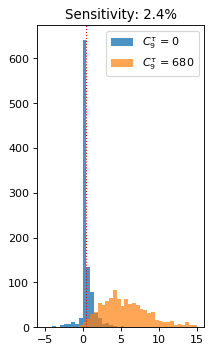

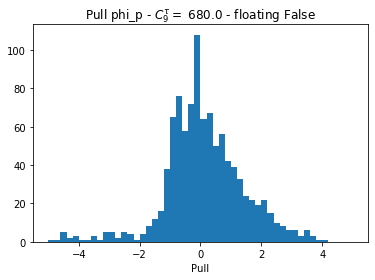

In [30]:
l = []
sensitivity = []

if load:
    CLs_values = -1*np.array(CLs_list)

if not os.path.exists('data/CLs/plots'):
    os.mkdir('data/CLs/plots')
    print("Directory " , 'data/CLs/plots' ,  " Created ")

print(np.shape(CLs_values))

figure(num=None, figsize=(2.7, 5), dpi=80, facecolor='w', edgecolor='k')

for step in range(1,ste):
    l.append(len(np.where(np.array(CLs_values[step]) < np.mean(CLs_values[0]))[0]))
    sensitivity.append(l[-1]/len(np.where(np.array(CLs_values[0]) < np.mean(CLs_values[0]))[0]))
    plt.clf()
    plt.title('Sensitivity: {:.1f}%'.format(sensitivity[-1]*100))
    plt.hist(CLs_values[0], bins = 40, range = (-5, 15), label = r'$C_9^\tau$' + ' = 0', alpha = 0.8)
    plt.hist(CLs_values[step], bins = 40, range = (-5, 15), label = r'$C_9^\tau$' + ' = {}'.format(int(np.around(Ctt_steps[step]))), alpha = 0.7)
#     plt.hist(CLs_values[0][np.where(np.array(CLs_values[0]) > np.mean(CLs_values[0]))[0]], bins = 40, range = (-5, 15), alpha = 0.9)
#     plt.hist(CLs_values[step][np.where(np.array(CLs_values[step]) < np.mean(CLs_values[0]))[0]], bins = 40, range = (-5, 15), alpha = 0.9)
    plt.axvline(x=np.mean(CLs_values[0]),color='red', linewidth=1.0, linestyle = 'dotted')
    plt.legend()
    plt.savefig('data/CLs/plots/CLs-Ctt({}).png'.format(int(np.around(Ctt_steps[step]))))

figure()    
    
for step in range(2*ste):
    if step%2 == 0:
        floaty = True
    else:
        floaty = False
    for key in pull_dic.keys():
        if not os.path.exists('data/CLs/plots/{}'.format(key)):
            os.mkdir('data/CLs/plots/{}'.format(key))
        plt.clf()
        plt.title(('Pull {} - ' + r'$C_9^\tau = $' + ' {} - floating {}').format(key, np.around(Ctt_steps[int(step/2)]), floaty))
        plt.hist(pull_dic[key][step], bins = 50, range = (-5,5))
        plt.xlabel('Pull')
        plt.savefig('data/CLs/plots/{}/{}Ctt{}s{}f.png'.format(key, np.around(Ctt_steps[int(step/2)]), step, floaty))

BR: 197.2464
0.7530487804878049

BR: 249.8238
0.6280487804878049

BR: 293.1172
0.510670731707317

BR: 330.7922
0.4222560975609756

BR: 364.5947
0.35365853658536583

BR: 395.5187
0.2926829268292683

BR: 424.1943
0.23932926829268292

BR: 451.0506
0.20884146341463414

BR: 476.3952
0.15701219512195122

BR: 500.4580
0.1402439024390244

BR: 523.4157
0.10365853658536585

BR: 545.4079
0.09451219512195122

BR: 566.5471
0.07164634146341463

BR: 586.9253
0.04725609756097561

BR: 606.6194
0.04420731707317073

BR: 625.6940
0.04725609756097561

BR: 644.2039
0.025914634146341462

BR: 662.1967
0.022865853658536585

BR: 679.7134
0.024390243902439025



<Figure size 432x288 with 0 Axes>

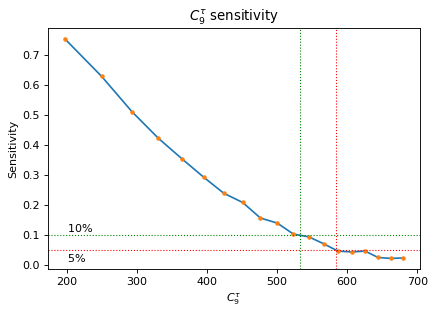

In [75]:
for s in range(len(l)):
    print('BR: {:.4f}'.format(Ctt_steps[s+1]))
    print(sensitivity[s])
    print()
#     print(l[s], len(CLs_values[s]))
#     print()
# print(len(CLs_values[0])/2)
# print(len(np.where(np.array(CLs_values[0]) < np.mean(CLs_values[0]))[0]))
plt.clf()
figure(dpi=80)
plt.title(r'$C_9^\tau$' + ' sensitivity')
plt.plot(Ctt_steps[1:], sensitivity)
plt.plot(Ctt_steps[1:], sensitivity, '.')
plt.axhline(y = 0.05 ,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axhline(y = 0.1 ,color='green', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x = 584.63 ,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x = 532.2 ,color='green', linewidth=1.0, linestyle = 'dotted')
# plt.axhline(x = 0.1 ,color='red', linewidth=1.0, linestyle = 'dotted')
plt.text(200, 0.11, r'$10\%$')
plt.text(200, 0.01, r'$5\%$')
plt.xlabel(r'$C_9^\tau$')
plt.ylabel('Sensitivity')
if scen == 'f1d1':
    plt.savefig('sensitivity_current.png')
else:
    
    plt.savefig('sensitivity_upgraded.png')
# plt.show()

In [72]:
# a = (sensitivity[-8]-sensitivity[-9])/(Ctt_steps[-8]-Ctt_steps[-9])
# print(sensitivity[-9])

0.10365853658536585


In [74]:
# Ctt_steps[-9]+(0.1-sensitivity[-9])/a

532.212578083589

## Nice plots of pulls for D contribs

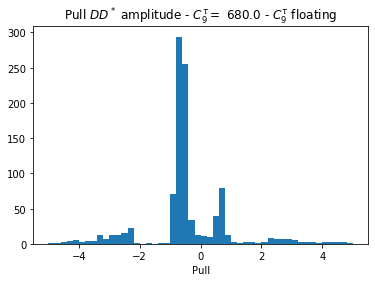

In [78]:
for step in range(2*ste):
    if step%2 == 0:
        floaty = True
    else:
        floaty = False
    for key in pull_dic.keys():
        if not key == 'DDstar_s':
            continue
        if not os.path.exists('data/CLs/plots/{}'.format(key)):
            os.mkdir('data/CLs/plots/{}'.format(key))
        plt.clf()
        plt.title('Pull ' + r'$DD^*$' + ' amplitude - ' + r'$C_9^\tau = $' + ' {} - '.format(np.around(Ctt_steps[int(step/2)])) + r'$C_9^\tau$' + ' floating')
        plt.hist(pull_dic[key][step], bins = 50, range = (-5,5))
        plt.xlabel('Pull')
        plt.savefig('data/CLs/plots/{}/DDstar-{}Ctt{}s{}f.png'.format(key, int(np.around(Ctt_steps[int(step/2)])), step, floaty))

In [ ]:
# for param in total_f_fit.get_dependents():
#     if param.floating:
#         print(params[param]['value'])

In [69]:
print(display_time(int(time.time()-start)))

56 s


# Smearing

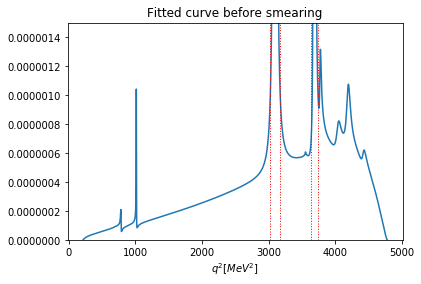

In [25]:
test_q = np.linspace(x_min, x_max, int(2e6))

probs = total_f_fit.pdf(test_q, norm_range=False)

calcs_test = zfit.run(probs)

plt.clf()
# plt.plot(x_part, calcs, '.')
plt.title('Fitted curve before smearing')
plt.plot(test_q, calcs_test)#, label = 'pdf (Ctt = 0.0)')
# plt.plot(test_q, calcs_test1, label = 'pdf (Ctt = 0.5)')
# plt.plot(test_q, calcs_test2, label = 'pdf (D-contribs = 0.3)')
# plt.plot(test_q, f0_y, label = '0')
# plt.plot(test_q, fT_y, label = 'T')
# plt.plot(test_q, fplus_y, label = '+')
# plt.plot(test_q, res_y, label = 'res')
plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.legend()
plt.ylim(0.0, 1.5e-6)
plt.xlabel(r'$q^2 [MeV^2]$')
# plt.yscale('log')
# plt.xlim(770, 785)
plt.savefig('fitted_before_smearing.png')

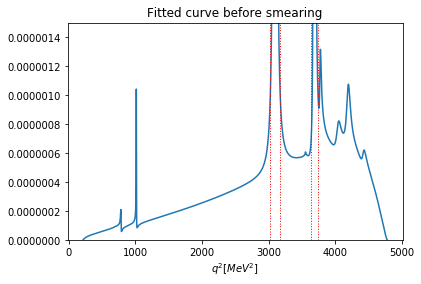

In [26]:
integrate = True

if integrate:

    probs = total_f_fit.pdf(test_q, norm_range=False)

    calcs_test1 = zfit.run(probs)
    
    plt.clf()
    plt.plot(test_q, calcs_test1)
    plt.title('Fitted curve before smearing')
    plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.ylim(0.0, 1.5e-6)
    plt.xlabel(r'$q^2 [MeV^2]$')
    plt.savefig('test.png')

In [27]:
# if integrate:

#     plt.clf()
#     plt.plot(test_q, calcs_test1)
#     plt.title('Fitted curve before smearing')
#     plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
#     plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
#     plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
#     plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
#     plt.ylim(0.0, 1.5e-6)
#     plt.xlabel(r'$q^2 [MeV^2]$')
#     plt.savefig('test.png')

## Integration

In [28]:
# total_f_fit.update_integration_options(draws_per_dim=2000000, mc_sampler=None)

if integrate:

    start = time.time()

    _max_size = 2000000

    step_size = 2000

    steps = np.arange(x_min, x_max, 0.1/step_size)

    l = len(steps)

    parts = int(l/_max_size)

    print(l)

    start_ = time.time()

    _list = []

    for j in range(parts):

        print(j, parts)

        _c = total_f_fit.pdf(steps[j*_max_size:(j+1)*_max_size], norm_range=False)

        inte_fl = zfit.run(_c)

        for i in range(int(_max_size/step_size)):
            _list.append(np.mean(inte_fl[int(i*step_size):int((i+1)*step_size)]))

    _c = total_f_fit.pdf(steps[(parts)*_max_size:], norm_range=False)

    inte_fl = zfit.run(_c)
    
    rest = l%_max_size

    for i in range(int(rest/step_size)):
        _list.append(np.mean(inte_fl[int(i*step_size):int((i+1)*step_size)]))

    print('Full integration finished in {}'.format(display_time(int(time.time()-start))))
    print(len(_list))

91404000
0 45
1 45
2 45
3 45
4 45
5 45
6 45
7 45
8 45
9 45
10 45
11 45
12 45
13 45
14 45
15 45
16 45
17 45
18 45
19 45
20 45
21 45
22 45
23 45
24 45
25 45
26 45
27 45
28 45
29 45
30 45
31 45
32 45
33 45
34 45
35 45
36 45
37 45
38 45
39 45
40 45
41 45
42 45
43 45
44 45
Full integration finished in 5 min, 35 s
45702


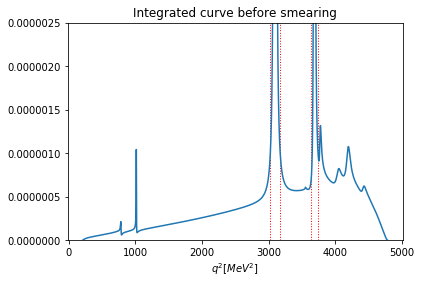

In [29]:
if integrate:

    dirName = 'data/CLs'
    with open("{}/inte_100keV_steps.pkl".format(dirName), "wb") as f:
        pkl.dump(_list, f, pkl.HIGHEST_PROTOCOL)

if integrate:
    
    center = np.arange(x_min+0.05, x_max, 0.1)

    probs = total_f_fit.pdf(test_q, norm_range=False)

    calcs_test1 = zfit.run(probs)
    
    plt.clf()
    plt.title('Integrated curve before smearing')
    plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
    plt.ylim(0.0, 2.5e-6)
    plt.plot(center,_list)
    plt.xlabel(r'$q^2 [MeV^2]$')
    plt.savefig('integrated_before_smearing.png')
# plt.plot(inte_fl)

## Smearing

In [30]:
def gauss(x, area, m, sig = 7, step_s = 0.1):
    
    prefac = 1/(sig*np.sqrt(np.pi))
    
    y = np.zeros(np.shape(x))
    
    start = time.time()
    
    for i in range(len(area)):
        
        y += prefac*area[i]*np.exp(-1/2*((x-m[i])/sig)**2)
        
        t = time.time()
        
        j = i+1
        
        if i % 500 == 0:
            print(display_time(int((t-start)/(j)*(len(area)-j))))
    
    return y*step_s*0.07
        
        
    

#             _y += prefac*area*np.exp(-1/2*((x-_m)/sig)**2)   

# gauss(scan_x, _list)

# print(np.shape(_list)[0], np.shape(center)[0])

# print(int(1.25/0.1)*0.1)

# print((1.25-1.25%0.1)/0.1)

# print((x_max-x_min)*10)

In [31]:
scan_x = np.linspace(x_min, x_max, 1e5)

center = np.arange(x_min+0.05, x_max, 0.1)

# for i in range(len(steps)/step_size):
#     center.append(i)


sum_y = gauss(x =scan_x, m = center, area = _list)

    

C:\Users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


12 min, 9 s
5 min, 29 s
5 min, 17 s
5 min, 18 s
5 min, 15 s
5 min, 8 s
5 min, 3 s
5 min
4 min, 56 s
4 min, 53 s
4 min, 50 s
4 min, 45 s
4 min, 41 s
4 min, 36 s
4 min, 32 s
4 min, 28 s
4 min, 25 s
4 min, 21 s
4 min, 17 s
4 min, 13 s
4 min, 9 s
4 min, 5 s
4 min, 1 
3 min, 57 s
3 min, 54 s
3 min, 50 s
3 min, 46 s
3 min, 42 s
3 min, 38 s
3 min, 35 s
3 min, 31 s
3 min, 27 s
3 min, 24 s
3 min, 20 s
3 min, 16 s
3 min, 13 s
3 min, 9 s
3 min, 5 s
3 min, 2 s
2 min, 58 s
2 min, 55 s
2 min, 51 s
2 min, 48 s
2 min, 44 s
2 min, 41 s
2 min, 37 s
2 min, 34 s
2 min, 30 s
2 min, 27 s
2 min, 23 s
2 min, 20 s
2 min, 16 s
2 min, 13 s
2 min, 9 s
2 min, 6 s
2 min, 2 s
1 min, 59 s
1 min, 55 s
1 min, 52 s
1 min, 48 s
1 min, 45 s
1 min, 41 s
1 min, 38 s
1 min, 34 s
1 min, 31 s
1 min, 28 s
1 min, 24 s
1 min, 21 s
1 min, 18 s
1 min, 14 s
1 min, 11 s
1 min, 7 s
1 min, 4 s
1 min, 1 
57 s
54 s
51 s
47 s
44 s
41 s
37 s
34 s
31 s
27 s
24 s
21 s
17 s
14 s
11 s
7 s
4 s
1 


C:\Users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


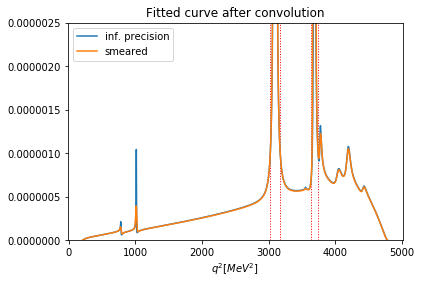

In [36]:
# plt.clf()
# plt.title('Fitted curve after smearing')
# plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
# plt.ylim(0.0, 2.5e-6)
# plt.plot(scan_x,sum_y)
# plt.xlabel(r'$q^2 [MeV^2]$')
# plt.savefig('curve_after_smearing.png')

C:\Users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app


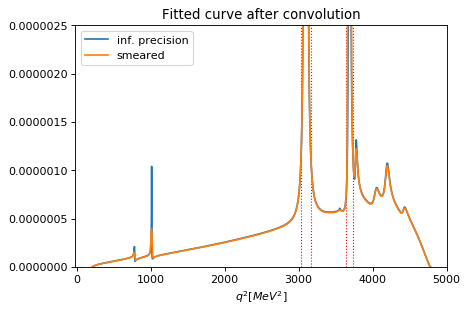

In [93]:
figure(num=None, dpi=80, facecolor='w', edgecolor='k')

plt.clf()
plt.title('Fitted curve after convolution')
plt.axvline(x=jpsi_mass -70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=jpsi_mass +70,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass -50,color='red', linewidth=1.0, linestyle = 'dotted')
plt.axvline(x=psi2s_mass +50,color='red', linewidth=1.0, linestyle = 'dotted')
plt.ylim(0.0, 2.5e-6)
plt.plot(test_q, calcs_test, label = 'inf. precision')
plt.plot(scan_x,sum_y, label = 'smeared')
plt.legend()
plt.xlabel(r'$q^2 [MeV^2]$')
# plt.xlim(jpsi_mass, psi2s_mass)
plt.savefig('curve_after_smearing-vs-before_smearing.png')

## Create convonluted data

[21.0, 46.0, 53.0, 76.0, 79.0, 115.0, 112.0, 93.0, 197.0, 119.0, 127.0, 147.0, 167.0, 179.0, 168.0, 177.0, 232.0, 277.0, 267.0, 307.0, 295.0, 298.0, 331.0, 373.0, 357.0, 406.0, 426.0, 441.0, 538.0, 568.0, 976.0, 2477115.0, 1213.0, 693.0, 665.0, 634.0, 659.0, 88601.0, 117254.0, 996.0, 761.0, 782.0, 879.0, 1033.0, 803.0, 686.0, 571.0, 475.0, 285.0, 90.0]


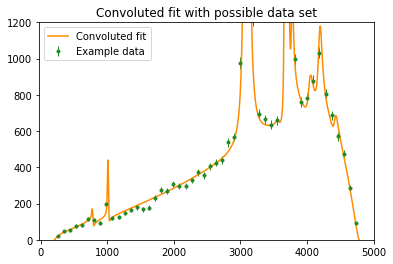

In [92]:
nbins = 50

b_w = int(len(scan_x)/nbins)

conv_data = []

means = []

_ = np.linspace(x_min, x_max, nbins+1)

bin_centers = []

_area = np.mean(sum_y)#*(x_max-x_min)

# print(_area)

_sum_y = sum_y/_area*pdg["number_of_decays"]/100

# print(np.mean(_sum_y))

for i in range(nbins):
    bin_centers.append((_[i]+_[i+1])/2.)
    means.append(np.mean(_sum_y[i*b_w:(i+1)*b_w]))
    _width = np.sqrt(means[-1])
    conv_data.append(np.around(np.random.normal(means[-1], _width)))
    
print(conv_data)

figure(num=None, dpi=80, facecolor='w', edgecolor='k')

plt.clf()
# plt.hist(x = bin_centers, bins = nbins, range = (x_min, x_max), weights = conv_data, histtype = 'step', label = 'Example data')
# plt.plot(bin_centers, conv_data, '.',, color = 'r')
plt.plot(scan_x,_sum_y, label = 'Convoluted fit', color = 'darkorange')
plt.errorbar(bin_centers, conv_data,yerr = np.sqrt(conv_data), elinewidth=1, fmt = '.', ecolor = 'forestgreen', color = 'forestgreen', label = 'Example data')
plt.ylim(0.,1200)
plt.legend()
plt.title('Convoluted fit with possible data set')
# plt.xlim(jpsi_mass, psi2s_mass)
# print(conv_data)
plt.savefig('smeared_fit_with_data.png')

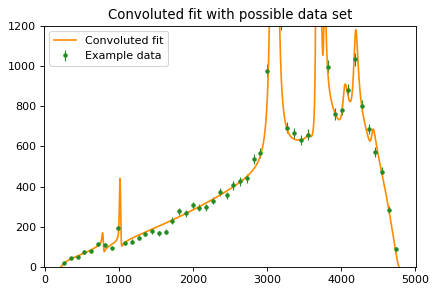

In [95]:
# figure(num=None, dpi=80, facecolor='w', edgecolor='k')

# plt.clf()
# # plt.hist(x = bin_centers, bins = nbins, range = (x_min, x_max), weights = conv_data, histtype = 'step', label = 'Example data')
# # plt.plot(bin_centers, conv_data, '.',, color = 'r')
# plt.plot(scan_x,_sum_y, label = 'Convoluted fit', color = 'darkorange')
# plt.errorbar(bin_centers, conv_data,yerr = np.sqrt(conv_data), elinewidth=1, fmt = '.', ecolor = 'forestgreen', color = 'forestgreen', label = 'Example data')
# plt.ylim(0.,1200)
# plt.legend()
# plt.title('Convoluted fit with possible data set')
# # plt.xlim(jpsi_mass, psi2s_mass)
# # print(conv_data)
# plt.savefig('smeared_fit_with_data.png')

In [ ]:
print 